In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop
!pip install -U --pre efficientnet
from efficientnet.tfkeras import EfficientNetB1
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
# Muat dataset Anda
# Tentukan direktori dataset Anda
num_classes = 2
dataset_dir = "/content/drive/MyDrive/Dataset"

# Inisialisasi daftar gambar sebagai daftar kosong
moi_images = []
non_moi_images = []

# Iterasi melalui direktori dataset
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            # Tentukan label gambar (0 untuk moi, 1 untuk non moi)
            label = 0 if "moi" in root else 1

            try:
                # Muat gambar dan ubah ukurannya menjadi 32x32 piksel
                image = Image.open(os.path.join(root, file))
                image = image.resize((32, 32))
                image = np.array(image)

                # Tambahkan gambar ke daftar yang sesuai
                if label == 0:
                    moi_images.append(image)
                else:
                    non_moi_images.append(image)
            except Exception as e:
                print(f"Error loading image: {file}")

# Cetak jumlah gambar dalam setiap daftar
print(f"Jumlah gambar moi: {len(moi_images)}")
print(f"Jumlah gambar non moi: {len(non_moi_images)}")

# Konversi daftar gambar menjadi array NumPy
x_train = np.array(moi_images + non_moi_images)

# Buat label untuk setiap gambar
y_train = np.array([0] * len(moi_images) + [1] * len(non_moi_images))

# Bagi dataset menjadi data pelatihan dan pengujian
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


Jumlah gambar moi: 448
Jumlah gambar non moi: 347


In [ ]:
print('Traning data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)

Traning data shape: (636, 32, 32, 3)
Testing data shape: (159, 32, 32, 3)


In [ ]:
y_train.shape, y_test.shape

((636,), (159,))

In [ ]:
import numpy as np

classes = np.unique(y_train)
nClasses = len(classes)

print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [ ]:
label_dict = {
 0: 'moi',
 1: 'non_moi',
}

Text(0.5, 1.0, '(Label: moi)')
Text(0.5, 1.0, '(Label: non_moi)')


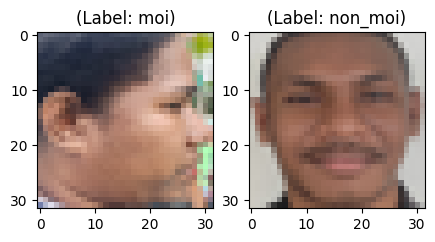

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[5,5])

# Display the first image in training data
index = 0
plt.subplot(121)
curr_img = np.reshape(x_train[index], (32,32,3))
plt.imshow(curr_img)
curr_label = str(label_dict[y_train[0]])
print(plt.title('(Label: {})'.format(curr_label)))

# Display the first image in testing data
index = 0
plt.subplot(122)
curr_img = np.reshape(x_test[index],(32,32,3))
plt.imshow(curr_img)
curr_label = str(label_dict[y_test[0]])
print(plt.title('(Label: {})'.format(curr_label)))

In [ ]:
np.min(x_train), np.max(x_train)

(0, 255)

In [ ]:
# Normalisasi data
# x_train = x_train / 255.0
# x_test = x_test / 255.0

In [ ]:
x_train_normalized = x_train/np.max(x_train)

np.min(x_train_normalized),np.max(x_train_normalized)

(0.0, 1.0)

In [ ]:
x_train_normalized.shape

(636, 32, 32, 3)

In [ ]:
from functools import reduce

n_cols = reduce((lambda x, y: x * y), x_train_normalized.shape[1:])
print(n_cols)

x_train_flat = x_train_normalized.reshape(-1, n_cols)
x_train_flat.shape

3072


(636, 3072)

In [ ]:
# Ratakan data
# x_train_flat = x_train.reshape(-1, 3072)
# x_test_flat = x_test.reshape(-1, 3072)

In [ ]:
feat_cols = ['pixel{}'.format(str(i)) for i in range(x_train_flat.shape[1])]

import pandas as pd

df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

df_cifar['label'] = y_train
df_cifar.shape

(636, 3073)

In [ ]:
df_cifar.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,0.364706,0.388235,0.458824,0.407843,0.427451,0.494118,0.384314,0.407843,0.470588,0.356863,...,0.835294,0.643137,0.533333,0.572549,0.427451,0.352941,0.317647,0.345098,0.396078,0
1,1.000000,1.000000,1.000000,0.815686,0.819608,0.854902,0.517647,0.552941,0.639216,0.470588,...,0.392157,0.294118,0.329412,0.341176,0.415686,0.709804,0.364706,0.529412,0.937255,0
2,0.843137,0.866667,0.850980,0.388235,0.435294,0.458824,0.192157,0.250980,0.298039,0.196078,...,0.823529,0.835294,0.890196,0.870588,0.882353,0.929412,0.921569,0.945098,0.956863,0
3,0.439216,0.435294,0.443137,0.270588,0.223529,0.231373,0.298039,0.235294,0.235294,0.313725,...,0.694118,0.639216,0.576471,0.811765,0.760784,0.701961,0.972549,0.917647,0.866667,0
4,0.721569,0.800000,0.803922,0.721569,0.800000,0.803922,0.717647,0.796078,0.800000,0.717647,...,0.537255,0.368627,0.278431,0.572549,0.494118,0.454902,0.525490,0.525490,0.521569,1


In [ ]:
from sklearn.decomposition import PCA

pca_cifar = PCA(n_components=3)
principalComponents_cifar = pca_cifar.fit_transform(df_cifar.iloc[:,:-1])

# # Terapkan PCA
# from sklearn.decomposition import PCA

# # Inisialisasi PCA dengan 90% varians yang dijelaskan
# pca = PCA(0.9)

# # Pasang PCA ke data pelatihan yang diratakan
# pca.fit(x_train_flat)


In [ ]:
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principal_cifar_Df['y'] = y_train

principal_cifar_Df.head()

,principal component 1,principal component 2,principal component 3,y
0,-5.616081,2.939577,0.693857,0
1,0.637041,3.890390,0.944011,0
2,-3.293064,3.137265,-0.466832,0
3,-3.971514,1.474459,-1.814527,0
4,8.338519,-0.021983,0.108084,1


In [ ]:
print('Explained variation per principal component: {}'.format(pca_cifar.explained_variance_ratio_))

Explained variation per principal component: [0.29828109 0.17803039 0.06007753]


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

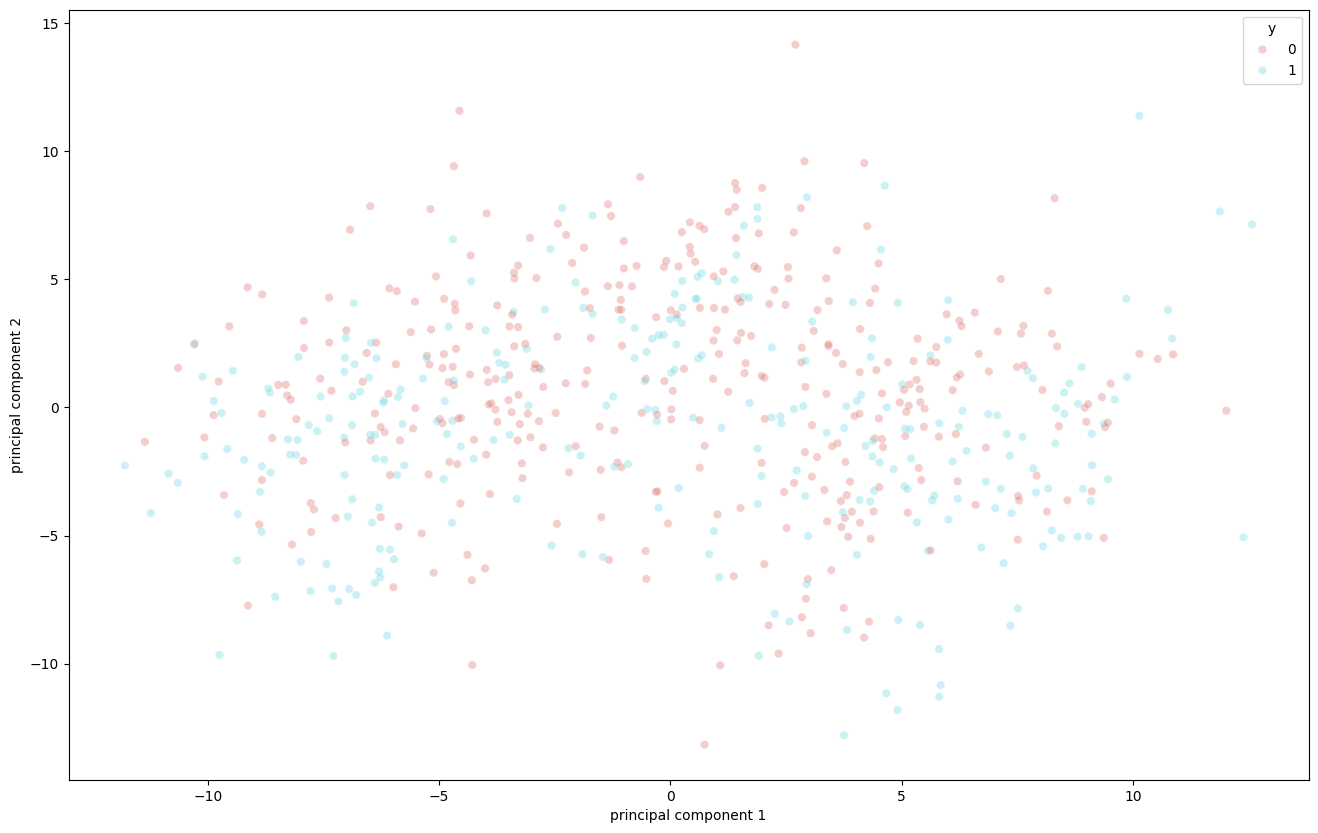

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=principal_cifar_Df,
    legend="full",
    alpha=0.3
)

<Axes: xlabel='principal component 2', ylabel='principal component 3'>

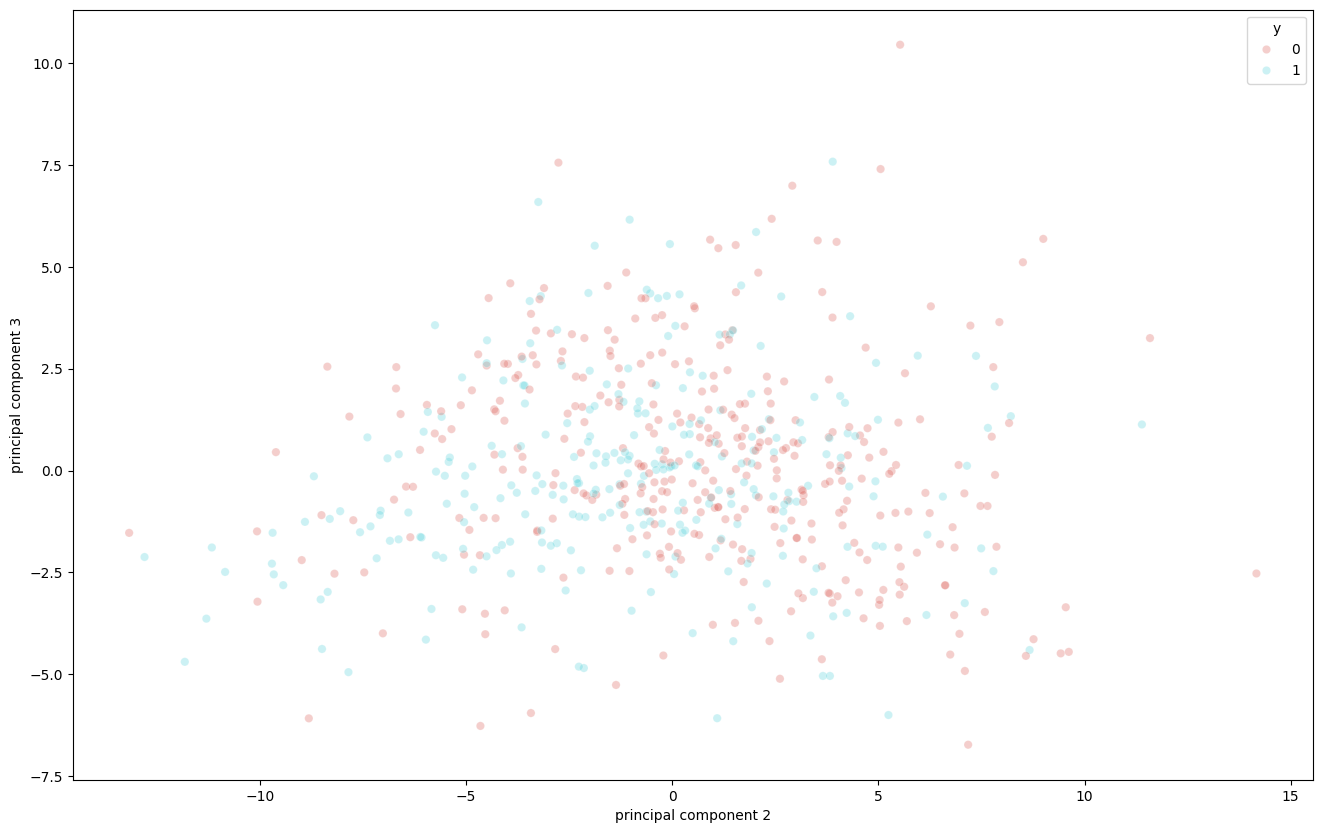

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='principal component 2', y='principal component 3',
    hue="y",
    palette=sns.color_palette('hls', 2),
    data=principal_cifar_Df,
    legend='full',
    alpha=0.3
)

In [ ]:
x_test_normalized = x_test/np.max(x_test)

x_test_flat = x_test_normalized.reshape(-1, n_cols)
x_test_flat.shape

(159, 3072)

In [ ]:
pca = PCA(0.9)

pca.fit(x_train_flat)

PCA(n_components=0.9)

In [ ]:
pca.n_components_

57

In [ ]:
# Transformasikan data pelatihan dan pengujian yang diratakan menggunakan PCA
train_img_pca = pca.transform(x_train_flat)
test_img_pca = pca.transform(x_test_flat)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import RMSprop

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
batch_size = 128
num_classes = nClasses
num_components = pca.n_components_
epochs = 20

In [ ]:
model = Sequential()
# model.add(Input(shape=(num_components,)))
# model.add(Dense(1024, activation='relu', input_shape=(57,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1024)              59392     
                                                                 
 dense_31 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dense_34 (Dense)            (None, 2)                 514       
                                                                 
Total params: 1765634 (6.74 MB)
Trainable params: 1765634 (6.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_img_pca, y_train, batch_size = batch_size ,epochs = epochs, verbose=1,
                    validation_data=(test_img_pca, y_test))

Epoch 1/20
5/5 [==============================] - 1s 111ms/step - loss: 0.9512 - accuracy: 0.5425 - val_loss: 0.6723 - val_accuracy: 0.6918
Epoch 2/20
5/5 [==============================] - 0s 63ms/step - loss: 0.6328 - accuracy: 0.6242 - val_loss: 0.5983 - val_accuracy: 0.7358
Epoch 3/20
5/5 [==============================] - 0s 57ms/step - loss: 0.5288 - accuracy: 0.7469 - val_loss: 0.6542 - val_accuracy: 0.6352
Epoch 4/20
5/5 [==============================] - 0s 82ms/step - loss: 0.5041 - accuracy: 0.7579 - val_loss: 0.4598 - val_accuracy: 0.7987
Epoch 5/20
5/5 [==============================] - 1s 101ms/step - loss: 0.4837 - accuracy: 0.7830 - val_loss: 0.4837 - val_accuracy: 0.7610
Epoch 6/20
5/5 [==============================] - 1s 107ms/step - loss: 0.3415 - accuracy: 0.8396 - val_loss: 0.6922 - val_accuracy: 0.6792
Epoch 7/20
5/5 [==============================] - 0s 96ms/step - loss: 0.3189 - accuracy: 0.8506 - val_loss: 0.4760 - val_accuracy: 0.8050
Epoch 8/20
5/5 [========

In [ ]:
# Evaluasi model
model.evaluate(test_img_pca, y_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.7966 - accuracy: 0.8050


[0.7966275811195374, 0.805031418800354]

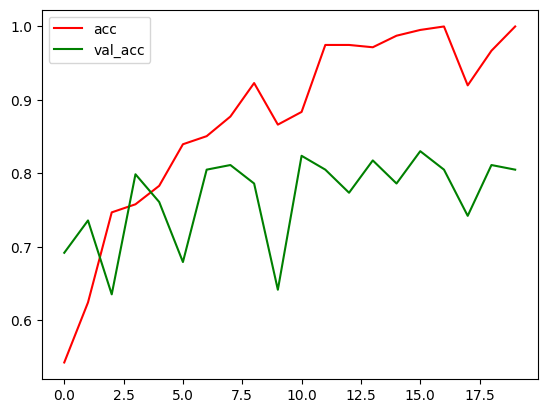

In [ ]:
# Visualisasikan hasil training

plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

5/5 [==============================] - 0s 12ms/step


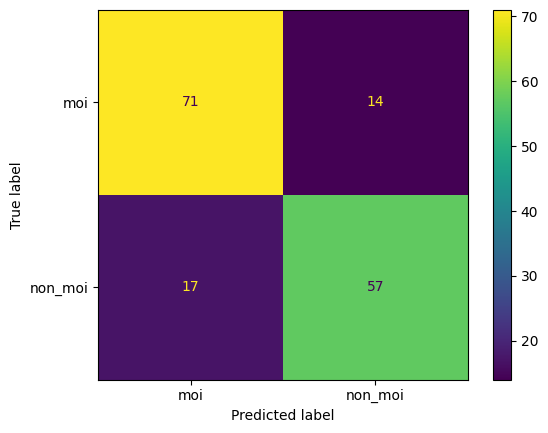

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Prediksi label kelas tunggal dari probabilitas yang diprediksi oleh model
y_pred = model.predict(test_img_pca).argmax(axis=1)

# Buat confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['moi', 'non_moi'])

# Visualisasikan confusion matrix
display.plot()
plt.show()

In [ ]:
# Muat dan proses gambar baru
new_image = Image.open("/content/drive/MyDrive/Dataset/rajaampat/rajaampat (97).jpg")  # Ganti dengan kode untuk memuat dan memproses gambar baru

# Ubah ukuran gambar baru menjadi 32x32 piksel
new_image = new_image.resize((32, 32))

pca = PCA(0.9)

pca.fit(x_train_flat)

# Konversi gambar baru menjadi array NumPy
new_image = np.array(new_image)

# Ratakan gambar baru
new_image_flat = new_image.reshape(1, -1)

# Terapkan PCA
new_image_pca = pca.transform(new_image_flat)

# Prediksi label kelas
prediction = model.predict(new_image_pca)

1/1 [==============================] - 0s 62ms/step


In [ ]:
labels = '''moi non_moi'''.split()

# Dapatkan label kelas yang diprediksi
predicted_class = np.argmax(prediction)
predicted_label = labels[np.argmax(prediction)]

# Cetak label kelas yang diprediksi
print("Label kelas yang diprediksi:", predicted_class, "\nlabel:", predicted_label)

Label kelas yang diprediksi: 1 
label: non_moi


In [ ]:

# Simpan model
model.save('PCA_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
